### Objectives

- Generate a dataset of simulated sequences to compare OrthoRep-evolved TrpBs to
- Compare simulated sequences to evolved sequences
- Analyze mutations within TrpB lineages
- Visualize mutations on structure images


### Usage

Change the `path_to_SA` variable appropriately.
Run the notebook using the conda environment that is used by maple. You may also need to install some additional packages such as pymol, and to get images to not have a watermark you will need to point pymol to a license file.

In [1]:
import pymol
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas
import datetime
import sys
import os
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import random
from Bio.Seq import Seq
import numpy as np
import scipy
import re
import bisect
from itertools import permutations
from timeit import default_timer as now
import bokeh
hv.extension('bokeh')

bokeh.io.output_notebook()

# full file path to the folder containing the SequenceAnalyzer.py and common.py files from github.com/gordonrix/maple
path_to_SA = '/home/redwood/Desktop/data_tools/maple/rules/utils'
sys.path.append(path_to_SA)
from SequenceAnalyzer import SequenceAnalyzer, SequenceEncoder
from common import conspicuous_mutations, export_svg_plots, cmap_dict, get_colors

from Bio import SeqIO
from Bio.Seq import Seq

output_dir = 'simulation_analysis_outputs'
os.makedirs(output_dir, exist_ok=True)

# whether or not to ray trace structure images. takes a long time
do_ray_trace = False

# Fasta file for saving/loading simulated sequences. To rerun generation of simulated sequences, ensure this file does not already exist
simulated_fasta = 'simulated.fasta'


Loading BokehJS ...

In [2]:

analyzer = SequenceAnalyzer(reference_fasta = '../ref/TrpB-ref.fasta', genotypesCSV = '../mutation_data/timepoints/TrpB-IE5_merged-timepoint_genotypes-reduced-dimensions.csv', exclude_indels=True)
mutations_of_interest = ['T292S', 'N167D', 'A118T', 'A118V', 'A20T', 'A20V'] # excluded but interesting: 'V291M', 'V183M', 'I271V', 'V152I', 'T259I', 'R171H'
positions = [mutation[:-1] for mutation in mutations_of_interest]
for position in positions:
    analyzer.genotypes[position] = analyzer.get_mutations_of_interest('AA', position, max_groups=10)
analyzer.genotypes.dtypes

genotype_ID                               int64
count                                     int64
NT_substitutions                         object
NT_substitutions_count                    int64
NT_insertions                            object
NT_deletions                             object
NT_insertion_length                       int64
NT_deletion_length                        int64
AA_substitutions_nonsynonymous           object
AA_substitutions_synonymous              object
AA_substitutions_nonsynonymous_count      int64
AA_insertions                            object
AA_deletions                             object
barcode(s)                               object
timepoint                                 int64
NT_PaCMAP1                              float64
NT_PaCMAP2                              float64
AA_PaCMAP1                              float64
AA_PaCMAP2                              float64
AA_muts_of_interest                      object
T292                                    

Calculating the pairwise amino acid and nucleotide hamming distances for the each timepoint

In [3]:
for tp in analyzer.genotypes['timepoint'].unique():
    print(f"timepoint: {tp}")
    print(f"\nnumber of genotypes: {len(analyzer.genotypes[analyzer.genotypes['timepoint'] == tp])}")
    df = analyzer.genotypes[analyzer.genotypes['timepoint'] == tp]
    if len(df) > 1000:
        df = df.sample(1000)
    analyzer.select(idx=df.index)
    NT_hamm_dist_matrix, _ = analyzer.HD_matrix_and_dist('NT')
    AA_hamm_dist_matrix, _ = analyzer.HD_matrix_and_dist('AA')

    print('NT mean HD:', np.mean(NT_hamm_dist_matrix))
    print('NT median HD:', np.median(NT_hamm_dist_matrix))
    print('AA mean HD:', np.mean(AA_hamm_dist_matrix))
    print('AA median HD:', np.median(AA_hamm_dist_matrix))
    print()

timepoint: 50

number of genotypes: 33889
NT mean HD: 22.224878
NT median HD: 22.0
AA mean HD: 14.54396
AA median HD: 14.0

timepoint: 70

number of genotypes: 37553
NT mean HD: 26.824308
NT median HD: 27.0
AA mean HD: 17.198716
AA median HD: 17.0

timepoint: 90

number of genotypes: 39687
NT mean HD: 30.696332
NT median HD: 31.0
AA mean HD: 19.106996
AA median HD: 19.0

timepoint: 110

number of genotypes: 39850
NT mean HD: 31.929206
NT median HD: 32.0
AA mean HD: 18.496084
AA median HD: 18.0

timepoint: 130

number of genotypes: 30306
NT mean HD: 33.858254
NT median HD: 34.0
AA mean HD: 19.152702
AA median HD: 19.0

timepoint: 150

number of genotypes: 30170
NT mean HD: 37.584316
NT median HD: 38.0
AA mean HD: 20.478988
AA median HD: 20.0

timepoint: 170

number of genotypes: 27990
NT mean HD: 39.365798
NT median HD: 40.0
AA mean HD: 20.61747
AA median HD: 21.0

timepoint: 190

number of genotypes: 19252
NT mean HD: 43.175392
NT median HD: 43.0
AA mean HD: 22.96009
AA median HD: 23.0

## Generating randomly mutated dataset for comparison

Some or all properties that we look at may be influenced by polymerase mutation rate bias and/or bias in what mutations are most accessible to the polymerase. To account for this, we generate a dataset of randomly mutated sequences to compare to the actual dataset. We'll first just check that this is valid by looking at codon usage and ensuring that codon usage isn't affected very much by evolution on average. I'll start with a codon usage bias table, which I'll convert into a format that will ignore the amino acid and will just give me the codon usage given an integer encoded codon

### Functions for simulating mutagenesis

In [4]:
# Precompute mutation weights for each position in the sequence
def precompute_mutation_weights(sequence, rates):
    # Define a mapping from nucleotide to its index in the array
    nucleotide_to_index = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    
    # Initialize a numpy array with zeros
    weights = np.zeros((len(sequence), 4))
    
    # Fill in the weights based on mutation rates and sequence nucleotides
    for i, nucleotide in enumerate(sequence):
        for mutation, rate in rates.items():
            original, mutated = mutation.split("->")
            if original == nucleotide:
                weights[i, nucleotide_to_index[mutated]] = rate
                
    return weights

def generate_mutation(sequence, rates, mutation_weights, stop_okay=False):
    """
    function to generate a single mutation in a nucleotide sequence based on the provided rates and weights.
    A mutation is chosen based on the weights at each position in the sequence, and the sequence is mutated
    accordingly. The function returns the mutated sequence and the updated mutation weights.

    args:
        sequence: list of str, nucleotide sequence to mutate
        rates: dict, mutation rates
        mutation_weights: np.array of shape (length of sequence, 4), precomputed mutation weights for the sequence
        stop_okay: bool, whether or not to allow the generated mutation to be a stop codon
    
    returns:
        str, str: mutated nucleotide sequence, mutation weights
    """

    nucleotide_to_index = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    mutations = ['A', 'T', 'C', 'G']

    accept_mutation = False

    while not accept_mutation:

        temp_sequence = sequence.copy()

        # Determine mutation index based on flattened weights
        flattened_weights = mutation_weights.flatten()
        if flattened_weights.sum() == 0:
            raise ValueError("No more mutations possible")
        flattened_weights /= flattened_weights.sum()  # Normalize the flattened weights
        mutation_index = np.random.choice(len(flattened_weights), p=flattened_weights)
        position, mutation_type = divmod(mutation_index, 4)
        
        wt_nt = temp_sequence[position]
        temp_sequence[position] = mutations[mutation_type]

        codon = position // 3
        codon_start = codon * 3
        original_AA = Seq.translate("".join(sequence[codon_start:codon_start+3]))
        mutated_AA = Seq.translate("".join(temp_sequence[codon_start:codon_start+3]))        

        if not stop_okay:
            if (mutated_AA == '*') and (original_AA != '*'):
                continue

        accept_mutation = True

    sequence = temp_sequence
    
    # update weights efficiently
    mt_nt = mutations[mutation_type]
    
    mutation_weights[position, nucleotide_to_index[wt_nt]] = rates[f"{mt_nt}->{wt_nt}"] # mutation back to previous sequence
    mutation_weights[position, nucleotide_to_index[mt_nt]] = 0                          # mutation to itself

    return sequence, mutation_weights, original_AA, mutated_AA

def generate_simulated_sequences(base, rates, num_muts_list):
    """
    function to generate a list of simulated sequences with a given number of synonymous mutations. 
    For each integer x in num_muts_list, take the base sequence and continuously mutate it according
    to the provided rates until x nonsynonymous mutations have occurred, and return the resulting
    nucleotide sequences as a list of length n=len(num_muts_list)

    args:
        base: str, nucleotide sequence to mutate
        rates: dict, mutation rates
        num_muts_list: list, number of synonymous mutations for sequences to contain
    
    returns:
        list of mutated amino acid sequences of length = len(num_muts_list) 
        with numbers of synonymous mutations that match num_muts_list
    """
    mutation_weights_OG = precompute_mutation_weights(base, rates)

    sequences = []
    counter = 0
    start = now()

    for num_muts in num_muts_list:
        sequence = list(base)
        synonymous_muts = 0
        nonsynonymous_muts = 0
        mutation_weights = mutation_weights_OG.copy()

        while synonymous_muts < num_muts:

            sequence, mutation_weights, original_AA, mutated_AA = generate_mutation(sequence, rates, mutation_weights)

            if original_AA == mutated_AA:
                synonymous_muts += 1
            else:
                nonsynonymous_muts += 1
            
        sequences.append( "".join(sequence) )

        counter += 1
        if counter % 10000 == 0: print(f"Generated {counter} sequences, {now() - start:.2f} seconds elapsed")
    if counter % 10000 != 0:
        print(f"Generated {counter} sequences, {now() - start:.2f} seconds elapsed")

    return sequences

def generate_mutation_3D_array(sequence_array, mutation_weights, mean_muts):
    """
    function to mutate a set of sequences represented as a 2D array such that it will have the given average number of mutations
    Note that this assigns all mutations at once, so the effects of iterative mutations are not observed
    (the np.random.choice function is too slow to operate on large arrays of probabilities many times)

    args:
        sequence_array: 2D np.array of shape (number of sequences, length of sequences), nucleotide sequences subject to mutation
        rates: dict, mutation rates
        mutation_weights: 3D np.array, precomputed mutation weights for all sequences
    
    returns:
        sequence_array:     2D np.array of shape (number of sequences, length of sequences), mutated nucleotide sequences
        nt_muts:            1D np.array of shape (number of sequences), number of nucleotide mutations in each sequence
        synonymous_muts:    1D np.array of shape (number of sequences), number of synonymous mutations in each sequence
        nonsynonymous_muts: 1D np.array of shape (number of sequences), number of nonsynonymous mutations in each sequence
    """

    mutations = ['A', 'T', 'C', 'G']
    num_sequences = sequence_array.shape[0]
    total_mutations = int(mean_muts * num_sequences)
    nt_muts, synonymous_muts, nonsynonymous_muts = (np.zeros(num_sequences) for _ in range(3))

    # Determine mutation indices based on flattened weights
    flattened_weights = mutation_weights.flatten()
    flattened_weights /= flattened_weights.sum()  # Normalize the flattened weights

    # sampling in bulk without replacement. Even at the highest number of generations, only <2% of mutations will be sampled, so it won't matter for this analysis.
    # Conclusions from simulation are more extensive and do involve replacement intrinsically because mutations are generated iteratively 
    mutation_indices_flat = np.random.choice(len(flattened_weights), replace=False, size=total_mutations, p=flattened_weights)

    for mutation_index_flat in mutation_indices_flat:
        sequence_index, position_index, nucleotide_index = np.unravel_index(mutation_index_flat, mutation_weights.shape)
        codon = position_index // 3
        codon_start = codon * 3
        original_AA = Seq.translate("".join(sequence_array[sequence_index,codon_start:codon_start+3]))
        sequence_array[sequence_index,position_index] = mutations[nucleotide_index]
        mutated_AA = Seq.translate("".join(sequence_array[sequence_index,codon_start:codon_start+3]))

        if original_AA == mutated_AA:
            synonymous_muts[sequence_index] += 1
        else:
            nonsynonymous_muts[sequence_index] += 1
        nt_muts[sequence_index] += 1

    return sequence_array, nt_muts, synonymous_muts, nonsynonymous_muts

def generate_simulated_sequences_mean_muts(base, rates, num_sequences, mean_muts):
    """
    function to generate a list of simulated sequences with a given mean number of nucleotide mutations. 
    For each integer x in num_muts_list, take the base sequence and continuously mutate it according
    to the provided rates until x nonsynonymous mutations have occurred, and return the resulting
    nucleotide sequences as a list of length n=len(num_muts_list) with mean mutations per sequence > mean_muts

    args:
        base: str, nucleotide sequence to mutate
        rates: dict, mutation rates
        num_sequences: int, number of sequences to generate
        mean_muts: float, mean number of mutations for sequences to contain
    
    returns:
        list of mutated amino acid sequences of length = len(num_muts_list) 
        with numbers of synonymous mutations that match num_muts_list
    """

    # expand mutation weights to the number of sequences to generate
    mutation_weights = np.array([precompute_mutation_weights(base, rates)] * num_sequences)

    # expand the base sequence to the number of sequences to generate
    sequences = np.array([list(base)] * num_sequences)

    sequences, nt_muts, synonymous_muts, nonsynonymous_muts = generate_mutation_3D_array(sequences, mutation_weights, mean_muts)

    return sequences, nt_muts, synonymous_muts, nonsynonymous_muts

# testing if this works by looking at a biased sequence and biased rates such that
#   we expect that the first half of the of the nucleotide sequence will have more mutations
#   but the amino acid sequence should have a similar number of mutations
# test_sequence_biased = "CCCCCCCCCGGGGGGGGG"
test_sequence_biased = "AACAACAACAAGAAGAAG"
test_rates_biased = {
    'A->T': 1e-6, 'A->C': 1e-6, 'A->G': 1e-6,
    'T->A': 1e-6, 'T->C': 1e-6, 'T->G': 1e-6,
    'C->A': 1e-4, 'C->T': 1e-4, 'C->G': 1e-4,
    'G->A': 1e-6, 'G->C': 1e-6, 'G->T': 1e-6,
}

test_num_muts_biased = [3]*10000

original_amino_sequence = Seq.translate(test_sequence_biased)

first_half_mutations_AA = 0
second_half_mutations_AA = 0
first_half_mutations_NT = 0
second_half_mutations_NT = 0

mutated_sequences = generate_simulated_sequences(test_sequence_biased, test_rates_biased, test_num_muts_biased)

for mutated_sequence_NT in mutated_sequences:

    mutated_sequence_AA = Seq.translate(mutated_sequence_NT)

    # Check mutations in the first half of amino acid sequences
    for i in range(len(original_amino_sequence) // 2):
        if original_amino_sequence[i] != mutated_sequence_AA[i]:
            first_half_mutations_AA += 1
    for i in range(len(test_sequence_biased) // 2):
        if test_sequence_biased[i] != mutated_sequence_NT[i]:
            first_half_mutations_NT += 1

    # Check mutations in the second half of amino acid sequences
    for i in range(len(original_amino_sequence) // 2, len(original_amino_sequence)):
        if original_amino_sequence[i] != mutated_sequence_AA[i]:
            second_half_mutations_AA += 1
    for i in range(len(test_sequence_biased) // 2, len(test_sequence_biased)):
        if test_sequence_biased[i] != mutated_sequence_NT[i]:
            second_half_mutations_NT += 1

print(f"{first_half_mutations_AA} and {second_half_mutations_AA} AA mutations in the first and second halves of the amino acid sequence, respectively")
print(f"{first_half_mutations_NT} and {second_half_mutations_NT} NT mutations in the first and second halves of the nucleotide sequence, respectively")
mutated_sequences = None

Generated 10000 sequences, 6.45 seconds elapsed
22148 and 6221 AA mutations in the first and second halves of the amino acid sequence, respectively
35375 and 10208 NT mutations in the first and second halves of the nucleotide sequence, respectively


Looks good. I'll first test the assumption that synonymous mutations are similar to what is expected throughout my TrpB evolution experiment. I'll do the same as above but instead of applying mutations to individual sequences I will apply mutations to a whole set of sequences and have the stop condition be hitting an average number of mutations per sequence, and I'll calculate the expected average from the mutation rate, # of generations, and length of sequences.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
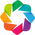

Loading BokehJS ...

:NdOverlay   [Element]
   :Histogram   [nonsynonymous]   (nonsynonymous_count)

In [9]:
sequence = test_sequence_biased*20
sequences, nt_muts, synonymous_muts, nonsynonymous_muts = generate_simulated_sequences_mean_muts(sequence, test_rates_biased, 10000, 20)

data = pd.DataFrame({'total':nt_muts, 'synonymous':synonymous_muts, 'nonsynonymous':nonsynonymous_muts})
min_val = min(data.min())
max_val = max(data.max())
bin_edges = np.arange(min_val-0.5, max_val+1.5, 1)
data.hvplot.hist(y=data.columns, bins=bin_edges, alpha=0.5)


Looks good. Now I'll import my mutation rates and use that information to generate a set of 10000 sequences per timepoint and compare synonymous and nonsynonymous mutations to the real data.

In [6]:
def get_longest_ORF(sequence):
    return max(re.findall(r'ATG(?:(?!TAA|TAG|TGA)...)*(?:TAA|TAG|TGA)',sequence), key = len)

# import polymerase data and use it to generate simulated dataset
badboy2_mutation_rates = (pd.read_csv('../../2022-08-05_HTS6_TPDNAP-DE5/mutation_data/DE5-mScarlettI/DE5-mScarlettI_mutation-rates-summary.csv', index_col=0)
                            .drop(columns=['all','deletion','insertion'])
                            .to_dict(orient='index')
                            ['BadBoy2'])
# badboy2_mutation_rates = {mut_type: float(rate.split(' ± ')[0]) for mut_type, rate in badboy2_mutation_rates.items()}

NT_wt_seq = get_longest_ORF(analyzer.ref_seq['NT'].string)

# num_muts_list = (analyzer.genotypes['NT_substitutions_count'] - analyzer.genotypes['AA_substitutions_nonsynonymous_count']).to_list()
# get nucleotide mutations just in the ORF by taking the integer encoded sequences, subtract the wild type sequence, and sum all non-0 positions to get the number of nucleotide mutations in each sequence ORF
start = analyzer.ref_seq['NT'].string.find(NT_wt_seq)
end = start + len(NT_wt_seq)
NT_wt_onehot = analyzer.ref_seq['NT'].integer[start:end]

# calculate synonymous mutations as the difference between total mutations and nonsynonymous mutations to account
#   for synonymous mutations that occur in the same codon as a nonsynonymous mutation
diff = analyzer.integer_matrix['NT'][:,start:end] - NT_wt_onehot[np.newaxis,:]
diff[diff != 0] = 1
num_syn_muts_list = (np.sum(diff, axis=1).astype(int) - analyzer.genotypes['AA_substitutions_nonsynonymous_count']).to_list()

analyzer.genotypes = analyzer.genotypes.assign(AA_substitutions_synonymous_count = num_syn_muts_list)

simulated_sequences_mean_muts = pd.DataFrame([], columns=['NT_substitutions_count', 'AA_substitutions_synonymous_count', 'AA_substitutions_nonsynonymous_count', 'timepoint'])

for tp in analyzer.genotypes['timepoint'].unique():
    print(f"generating sequences for timepoint {tp}")
    badboy2_overall = (pd.read_csv('../../2022-08-05_HTS6_TPDNAP-DE5/mutation_data/DE5-mScarlettI/DE5-mScarlettI_mutation-rates-summary.csv', index_col=0)
                            ['all']['BadBoy2'])
    num_sequences = 10000
    average_mutations = badboy2_overall * len(NT_wt_seq) * tp
    sequences, nt_muts, synonymous_muts, nonsynonymous_muts = generate_simulated_sequences_mean_muts(NT_wt_seq, badboy2_mutation_rates, num_sequences, average_mutations)
    data = pd.DataFrame({'NT_substitutions_count':nt_muts, 'AA_substitutions_synonymous_count':synonymous_muts, 'AA_substitutions_nonsynonymous_count':nonsynonymous_muts})
    data['timepoint'] = tp
    simulated_sequences_mean_muts = pd.concat([simulated_sequences_mean_muts, data])


generating sequences for timepoint 50
generating sequences for timepoint 70
generating sequences for timepoint 90
generating sequences for timepoint 110
generating sequences for timepoint 130
generating sequences for timepoint 150
generating sequences for timepoint 170
generating sequences for timepoint 190
generating sequences for timepoint 210
generating sequences for timepoint 230
generating sequences for timepoint 300
generating sequences for timepoint 350
generating sequences for timepoint 420
generating sequences for timepoint 480
generating sequences for timepoint 540


In [10]:
# plotting

plots = []
analyzer.genotypes = analyzer.genotypes.assign(AA_substitutions_synonymous_count = num_syn_muts_list)

mut_types = ['NT_substitutions_count', 'AA_substitutions_synonymous_count', 'AA_substitutions_nonsynonymous_count']
for column in mut_types:
    real = analyzer.genotypes.hvplot.violin(by='timepoint', y=column, c='timepoint', cmap='bmy_r').opts(outline_alpha=0, violin_fill_alpha=1)
    simulated = simulated_sequences_mean_muts.hvplot.violin(by='timepoint', y=column, c='grey').opts(outline_alpha=0, violin_fill_alpha=1)
    plots.append(simulated * real)

export_svg_plots(plots, f'{output_dir}/sim_by_mean_muts.html', labels=[f'{mt}' for mt in mut_types])
hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Violin.I  :Violin   [timepoint]   (NT_substitutions_count)
      .Violin.II :Violin   [timepoint]   (NT_substitutions_count)
   .Overlay.II  :Overlay
      .Violin.I  :Violin   [timepoint]   (AA_substitutions_synonymous_count)
      .Violin.II :Violin   [timepoint]   (AA_substitutions_synonymous_count)
   .Overlay.III :Overlay
      .Violin.I  :Violin   [timepoint]   (AA_substitutions_nonsynonymous_count)
      .Violin.II :Violin   [timepoint]   (AA_substitutions_nonsynonymous_count)

Looks like synonymous mutations diverge far less than nonsynonymous mutations so it should be pretty safe to use synonymous mutations as a molecular clock. Generating simulated sequences in this way. Saving them to a file so that I can use the same exact set of sequences if I need to redo anything

In [8]:
if not os.path.exists(simulated_fasta):
    print('Generating simulated dataset...')

    # generate simulated dataset
    sequences_simulated = generate_simulated_sequences(NT_wt_seq, badboy2_mutation_rates, num_syn_muts_list)

    with open(simulated_fasta, 'w') as fasta_AA, open(simulated_fasta.replace('.fasta','_NT.fasta'), 'w') as fasta_NT:
        fasta_AA.write('>reference\n')
        fasta_NT.write('>reference\n')
        fasta_AA.write(analyzer.ref_seq['AA'].string + '\n')
        fasta_NT.write(analyzer.ref_seq['NT'].string + '\n')
        for i, sequence_NT in enumerate(sequences_simulated):
            sequence_AA = Seq.translate(sequence_NT)
            fasta_AA.write(f'>simulated_{i}\n')
            fasta_AA.write(sequence_AA + '\n')
            fasta_NT.write(f'>simulated_{i}\n')
            fasta_NT.write(sequence_NT + '\n')
            
    sequences_simulated = None

simulated_analyzer = SequenceAnalyzer(MSA_fasta=simulated_fasta)
simulated_analyzer.integer_matrix['AA'].shape

reference fasta file not input, will use first sequence in MSA fasta as reference


(427403, 398)

I'll now construct a genotypes dataframe for these sequences and save them to an analyzer object. I'll also copy over some of the data that I'll need to reference such as timepoints and counts

In [11]:
ref = simulated_analyzer.ref_seq['AA'].integer
AA_substitutions_list = []
AA_substitutions_count_list = []
AAs = simulated_analyzer.characters['AA']
start = now()

for i in range(simulated_analyzer.integer_matrix['AA'].shape[0]):
    AA_substitutions = []
    seq = simulated_analyzer.integer_matrix['AA'][i,:]
    diff = np.where(seq != ref)[0]
    for position in diff:
        AA_substitutions.append(f'{AAs[ref[position]]}{position+1}{AAs[seq[position]]}')
    nonsyn_count = len(AA_substitutions)
    AA_substitutions_count_list.append(nonsyn_count)
    if nonsyn_count > 0:
        AA_substitutions = ', '.join(AA_substitutions)
    else:
        AA_substitutions = np.nan
    AA_substitutions_list.append(AA_substitutions)
    if i%100000 == 0:
        print(f'{i} sequences processed, {now()-start} seconds elapsed')

simulated_analyzer.genotypes = pd.concat([analyzer.genotypes[['count','timepoint']], pd.DataFrame({'AA_substitutions_nonsynonymous':AA_substitutions_list, 'AA_substitutions_nonsynonymous_count':AA_substitutions_count_list})], axis=1)
simulated_analyzer.genotypes

0 sequences processed, 0.18899196200072765 seconds elapsed
100000 sequences processed, 1.2304708287119865 seconds elapsed
200000 sequences processed, 2.69300365075469 seconds elapsed
300000 sequences processed, 4.6399601604789495 seconds elapsed
400000 sequences processed, 7.227042386308312 seconds elapsed


,count,timepoint,AA_substitutions_nonsynonymous,AA_substitutions_nonsynonymous_count
0,55,50,NaN,0
1,3,50,NaN,0
2,1,50,NaN,0
3,3,50,"E168G, G253S, S368F",3
4,3,50,NaN,0
...,...,...,...,...
427398,1,540,"G3S, G10N, A26T, E29K, E35K, S36F, F37L, R46H,...",60
427399,1,540,"G3S, E15K, A20V, E23K, R46S, P52L, G80D, A81E,...",40
427400,1,540,"M1V, K2N, I31F, F37L, R51C, E63K, R73C, E74K, ...",51
427401,1,540,"G6S, L17P, L21P, E23G, L44P, E63G, V91I, G98N,...",46


Later on I'll use this to look at the isoelectric point and gravy of each protein sequence and see if this changes throughout the evolution and compare this to the same calculation performed for the simulated sequences. However, I also want to determine what regions of the structure most play a role in the changes we might observe. To do that, I need to classify each residue according to its location in the structure. We will use pymol to do this.

### Build base pymol session

To analyze the relationship between mutations and structure, I'll create a pymol session that takes a bit of time to create but will be an easy jumping off point for further visualization. I'm using an alphafold structure for wild type TmTrpB to visualize mutations. I'll align it to known crystal structures to assign residue roles based on proximity to TrpA/TrpB/substrate. I'll color the different regions of TrpB according to their role in the structure as well as what they are responsible for. In conjunction with coloring, I'll also build a dictionary to keep track of the category for each residue, which I'll use later for examining how mutations vary among the different groups.

Note: you'll see a watermark in the png ray trace exports unless you place a license file named license.lic in the share/pymol folder of the environment in which your pymol is installed

In [12]:
from pymol import cmd
import numpy as np
from statistics import mean

cmd.reinitialize()

# visual settings

# # Light/rendering effects
cmd.set("specular", 0)
cmd.set("ray_shadow", "off")
cmd.set("antialias", 2)
cmd.set("ray_trace_mode", 1)
cmd.set("ray_trace_disco_factor", 1)
cmd.set("ray_trace_gain", 1)
cmd.set("power", 0.2)
cmd.set("ambient", 0.4)
cmd.set("direct", 0.45)

# Structure preferences
cmd.set("line_width", 6)
# cmd.set("cartoon_transparency", 0.25)

# Color preferences
cmd.set_color("nitrogen", [2, 118, 253])
cmd.set_color("pymol_gray", [52, 52, 52])
cmd.set_color("light_gray", [175, 175, 175])
cmd.set_color("very_light_gray", [225, 225, 225])
cmd.set_color("good_yellow", [250, 199, 44])
cmd.set_color("good_teal", [40, 176, 193])
cmd.set_color("good_green", [170, 195, 47])
cmd.set_color("good_pink", [236, 114, 164])
cmd.set_color("good_peach", [249, 145, 120])
cmd.set_color("good_blue", [68, 153, 231])

cmd.bg_color("very_light_gray")
cmd.set("ray_opaque_background", "off")

# Load the AlphaFold predicted TmTrpB structure
cmd.load("tmTrpB_wt_alphafold.pdb", "alphafold")
cmd.color("pymol_gray", "alphafold")

# Fetch PfTrpS complex and use it to find A-B interface residues
TrpS_code = '5E0K'
cmd.fetch(TrpS_code, "PfTrpS")
cmd.align("alphafold", "PfTrpS")
cmd.select("close_to_A", "br. alphafold within 5 of PfTrpS and chain A")
cmd.remove('PfTrpS')

# Fetch PfTrpB and use it to find B-B interface residues and active site
TrpB_code = '5DW3'
cmd.fetch(TrpB_code, "PfTrpB")
cmd.color("black", "alphafold")
cmd.align("alphafold", "PfTrpB")
cmd.select('llp_residue', 'PfTrpB and resn LLP and resi 82 and chain A')
cmd.select('llp_exclude', 'PfTrpB and resn LLP and resi 82 and chain A and (name N+C+CA+O+CB)')
cmd.select('llp_refined', 'llp_residue and not llp_exclude')
cmd.select('substrate', '(PfTrpB and resn TRP and resi 402 and chain A) or llp_refined')
cmd.select("active_site_residues", "br. alphafold within 5 of substrate")
cmd.select("close_to_B", "br. alphafold within 5 of PfTrpB and chain B")
cmd.origin('substrate')
cmd.center('substrate')
cmd.show('sticks', 'substrate')
cmd.color('black', 'substrate')
cmd.color("blue", "substrate and elem N")  # Color nitrogen atoms blue
cmd.color("red", "substrate and elem O")   # Color oxygen atoms red
cmd.color("orange", "substrate and elem P")  # Color phosphorus atoms orange
cmd.remove('PfTrpB and not substrate')

buried_residues = ''
surface_exposed_residues = ''
COMM_residues = ''

# loop through residues and classify them as COMM, B-B interface, A-B interface, surface (but not COMM of interface), buried, or active site
residue_classes = {}
for chain in cmd.get_chains('alphafold'):
    # Iterate over the selection to get residue information
    residues = []
    cmd.iterate(f"alphafold and chain {chain}", "residues.append((resi, resn))", space=locals())
    residues = list(dict.fromkeys(residues))
    relative_sasa_arr = np.zeros((len(residues)))
    for position, residue in residues:
        selection = f'alphafold and chain {chain} and resi {position}'

        # Skip if the residue is in the active site
        if cmd.count_atoms(f'{selection} and active_site_residues') > 0:
            residue_classes[position] = 'active-site'
            continue

        # skip if the residue is in the COMM domain (G98 - G185)
        if 98 <= int(position) <= 185:
            residue_classes[position] = 'COMM'
            COMM_residues += f' or {selection}'
            continue

        # skip if residue is in the B-B interface
        if cmd.count_atoms(f'{selection} and close_to_B') > 0:
            residue_classes[position] = 'B-B-interface'
            continue

        # skip if residue is in the A-B interface
        if cmd.count_atoms(f'{selection} and close_to_A') > 0:
            residue_classes[position] = 'B-A-interface'
            continue

        relative_sasa = cmd.get_sasa_relative(selection)
        mean_relative_sasa = mean(relative_sasa.values())
        relative_sasa_arr[int(position)-1] = mean_relative_sasa
        
        if mean_relative_sasa < 0.2:
            classification = "buried"
            buried_residues += f' or {selection}'
        else:
            classification = "surface"
            surface_exposed_residues += f' or {selection}'
        residue_classes[position] = classification

cmd.color("good_pink", surface_exposed_residues[4:])
cmd.color("good_peach", "close_to_B")
cmd.color("good_green", "close_to_A")
cmd.color("good_teal", COMM_residues[4:])
cmd.color("good_yellow", "active_site_residues")
cmd.color("white", buried_residues[4:])

# two good views, front and back
def set_view(front_or_back):
    if front_or_back == 'front':
        cmd.set_view([
            0.445815861,    0.209886849,   -0.870152175,
            -0.721975744,   -0.490318269,   -0.488170952,
            -0.529123962,    0.845882893,   -0.067065097,
            0.000439622,    0.000030668, -190.134109497,
            83.023880005,   13.196344376,  195.952026367,
            96.590087891,  288.761566162,  -20.000000000
        ])
        
    elif front_or_back == 'back':
        cmd.set_view([
            -0.524435639,    0.251267314,    0.813516855,
            0.656474531,   -0.489122927,    0.574272990,
            0.542211592,    0.835242033,    0.091565348,
            0.000439622,    0.000030668, -190.134109497,
            83.023880005,   13.196344376,  195.952026367,
            96.590087891,  288.761566162,  -20.000000000 
        ])
    else:
        print('front_or_back must be either "front" or "back"')
    return

set_view('front')

# save pymol session and export ray traced
cmd.save(f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.pse")
t0=now()
if do_ray_trace:
    print(f'beginning ray tracing')
    cmd.png(f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.png", dpi=300, width=2400, height=2400, ray=1)
    print(f'completed ray tracing. elapsed time: {now()-t0}')



How many residues are in each category?

In [13]:
counter = {}

for position in residue_classes:
    resiclass = residue_classes[position]
    if resiclass not in counter:
        counter[resiclass] = 1
    else:
        counter[resiclass] += 1
print(counter)

{'surface': 83, 'buried': 131, 'B-A-interface': 27, 'B-B-interface': 35, 'active-site': 36, 'COMM': 77}


### Pymol functions

Making a function that will load in the previously generated pymol session and generate a heatmap on the structure from the dataset. Specific indices are chosen, and these are used to find the frequency of each mutation, and this frequency is used to color residues above some frequency of appearance

In [14]:
def hex_to_rgb(hex_code):
    # Extract the red, green, and blue parts from the hex string
    r = int(hex_code[1:3], 16)
    g = int(hex_code[3:5], 16)
    b = int(hex_code[5:7], 16)
    
    # Normalize to the 0-1 range
    return [r/255.0, g/255.0, b/255.0]

def get_RGB_color_from_proportion(proportion, colormap):
    color_list = cmap_dict()[colormap]
    index = int(proportion * (len(color_list) - 1))
    hex = color_list[index]
    return hex_to_rgb(hex)

def structure_heatmap(df, selection, ray_trace=False, num_positions=20, proportion_threshold=0.01, rescale=True, uniform_color=False, cmap='bmy_r', input_file=None, output_file=None, erase=True):
    """
    Creates a heatmap of the proportion of sequences that have a mutation at each residue position.
    Transparency of spheres for each residue is used to convey the frequency of any mutation at that position
    Optionally, color is also used.

    args:
        df: dataframe with columns 'position' and 'proportion_of_seqs'
        selection: selection of residues to create the heatmap for
        ray_trace: whether to export a ray traced png image of the structure
        num_positions: int, number of positions to include in the heatmap
        rescale: whether to rescale the proportion of sequences to be between 0 and 1
        uniform_color: whether to color all spheres the same color (True) or
            to color each sphere according to the bmy heatmap (False)
        uniform_sphere_opacity: whether to set the opacity of all spheres to be the same (True) or
            to set the opacity of each sphere according to the proportion of sequences with a mutation at that position (False)
        input_file: path to input file to load into PyMOL
        output_file: path to output file to save PyMOL session
        erase: whether to erase the new objects after saving the PyMOL session
        backbone_opacity: opacity of the backbone of the heatmap residues
    
    returns:
        None
    """
    if input_file:
        cmd.reinitialize()
        cmd.load(input_file)

    # Group by position and sum up proportions
    aggregated_df = (df.groupby('position')['proportion_of_seqs'].sum().reset_index().sort_values(['proportion_of_seqs'], ascending=False))

    if rescale:
        aggregated_df['proportion_of_seqs'] = aggregated_df['proportion_of_seqs'] / aggregated_df['proportion_of_seqs'].max()
    # Grab only the top num_mutations positions
    if num_positions:
        spheres_positions = aggregated_df['position'].iloc[:num_positions].tolist()
        # surface_conserved = aggregated_df['position'].iloc[-num_positions:]
        # surface_conserved = [resi for resi in surface_conserved if residue_classes.get(str(resi), 'active-site') not in ['active-site', 'buried']]
        # positions = positions + surface_conserved
        # aggregated_df = (aggregated_df[aggregated_df['position'].isin(positions)]
        #                  .sort_values('position', ascending=True))

    if uniform_color:
        cmd.set_color("uniform_color", get_RGB_color_from_proportion(0.9, cmap))

    # recolor structure cartoon as grey
    cmd.color("light_gray", selection)

    new_objects = []

    # For each aggregated position-proportion pair
    for index, row in aggregated_df.iterrows():
        position = int(row['position'])
        if row['proportion_of_seqs'] < proportion_threshold:
            continue
        
        # Create a new object for the specific residue position so that the original is not modified
        residue = f"{selection} and resi {position}"
        cmd.set_color(f'temp_resi{position}', get_RGB_color_from_proportion(row['proportion_of_seqs'], cmap))
        cmd.color(f'temp_resi{position}', residue)

        if position in spheres_positions:
            cmd.select(f'{position}_exclude', f'{residue} and (name N+O)') # we dont want to color the backbone
            new_object_selection = f'{residue} and not ({position}_exclude)'
            new_object = f'res_{position}'
            cmd.create(new_object, new_object_selection)
            new_objects.append(new_object)

            # # Set the color and representation for the specific residue position
            cmd.show("spheres", new_object)

            cmd.color(f'temp_resi{position}', new_object)
            

    set_view('front')
    cmd.rebuild()
    if output_file:
        cmd.save(output_file)
        if ray_trace:
            t0=now()
            print(f'beginning ray tracing')
            cmd.png(output_file[:-3]+'png', dpi=300, width=2400, height=2400, ray=1)
            print(f'completed ray tracing. elapsed time: {now()-t0}')
    if erase:
        for new_object in new_objects:
            cmd.delete(new_object)
    
    return

structure_heatmap(analyzer.aggregate_mutations('AA'), 'alphafold and chain B', ray_trace=do_ray_trace, input_file=f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.pse", output_file=f"{output_dir}/tmTrpB_IE5_all_heatmap.pse")

Now we can generate a big table with all the information on physicochemical properties and how they relate to structure. We will do this for both the real dataset and the simulated dataset. To save compute we will just loop through the mutations for each sequence where we can. For isoelectric point and hydrophobicity, only calculating for the full sequence using the ProteinAnalysis() class from biopython, although I also use the Kyte-Doolittle hydrophobicity scale for calculating hydrophobicity of regions. Calculating the following by region:
    - number of mutations
    - number of mutations that are frequently found in thermophile to mesophile evolution
    - charge change
    - hydrophobicity change

In [15]:
amino_acid_hydrophobicity = {
    'A': 1.8,  'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8,  'K': -3.9, 'M': 1.9,  'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2,
    '*': 0
}

# note this is just for rough charge approximation, not used for isoelectric point
amino_acid_charge = {
    'A': 0, 'C': 0, 'D': -1, 'E': -1,
    'F': 0, 'G': 0, 'H': 0, 'I': 0,
    'K': 1, 'L': 0, 'M': 0, 'N': 0,
    'P': 0, 'Q': 0, 'R': 1, 'S': 0,
    'T': 0, 'V': 0, 'W': 0, 'Y': 0,
    '*': 0
}

#  thermophile to mesophile replacements most biased in number, p < 0.005
#  from https://www.pnas.org/doi/epdf/10.1073/pnas.96.7.3578
biased_replacements_list = ['AS','RK','KS','IL','TS','KN','LM','EN','AG','IT','ES','KQ','VT','EA','PS','ET','PA']

AAs = amino_acid_hydrophobicity.keys()
biased_replacements = {(wt,mt):0 for wt,mt in permutations(AAs,2)}
for pair in biased_replacements_list:
    wt,mt = pair[0],pair[1]
    biased_replacements[(wt,mt)] = 1

region_deltas = []
delta_types = ['charge', 'hydrophobicity']
regions = ['all', 'buried', 'surface', 'B-A-interface', 'B-B-interface', 'active-site', 'COMM']
for region in regions:
    region_deltas.extend([f'{region}_{delta_type}_delta' for delta_type in delta_types])
    region_deltas.append(f'{region}_num-muts')
    region_deltas.append(f'{region}_meso-muts')

# getting the charge and hydrophobicity of each region in the wild type sequence
region_property_wt = {}
for region in regions:
    for property in delta_types:
        region_property_wt[f'{region}_{property}'] = 0
for i, AA in enumerate(analyzer.ref_seq['AA'].string):
    position = str(i+1)
    if position in residue_classes:
        region = residue_classes[position]
        region_property_wt[f'{region}_hydrophobicity'] += amino_acid_hydrophobicity[AA]
        region_property_wt[f'{region}_charge'] += amino_acid_charge[AA]
    region_property_wt[f'all_hydrophobicity'] += amino_acid_hydrophobicity[AA]
    region_property_wt[f'all_charge'] += amino_acid_charge[AA]

physicochemical_properties = ['isoelectric_point', 'gravy']

columns=['variant_idx', 'timepoint', 'barcode'] + physicochemical_properties + region_deltas + list(region_property_wt.keys())
rows = []

for seq_analyzer in [analyzer, simulated_analyzer]:
    
    rows = []

    # loop through each variant and get the isoelectric point and hydrophobicity for the sequence
    #   and calculate the charge and hydrophobicity delta for each type of residue
    for variant_idx, row in seq_analyzer.genotypes.iterrows():

        if 'barcode(s)' in row:
            bc = row['barcode(s)']
        else:
            bc = 'none'

        genotype_row = [variant_idx, row['timepoint'], bc]

        integer_encoded_seq = seq_analyzer.integer_matrix['AA'][variant_idx,:]
        
        sequence_line = ''.join( seq_analyzer.ref_seq['AA'].decode_integer(integer_encoded_seq) )[:-1]# remove stop codon
        if '*' in sequence_line: # skip sequences with premature stop codon
            genotype_row.extend([np.nan, np.nan])
        else:
            analyzed_seq = ProteinAnalysis(sequence_line)
            genotype_row.extend([analyzed_seq.isoelectric_point(), analyzed_seq.gravy()])

        mutations = row['AA_substitutions_nonsynonymous']
        if type(mutations) == str:
            mutations = mutations.split(', ')
        else:
            mutations = []
        
        deltas = {delta_type: 0 for delta_type in region_deltas} # differences between wild type and mutant, including mutations
        totals = region_property_wt.copy()                      # totals for each region
        for mutation in mutations:
            try:
                wt_aa, position, mt_aa = mutation[0], mutation[1:-1], mutation[-1]
            except:
                print(variant_idx, mutation)
                raise ValueError
            biased_replacement = biased_replacements[(wt_aa,mt_aa)]
            if int(position) > 389: # HIS tag and stop codon not considered
                continue
            deltas[f'all_charge_delta'] += amino_acid_charge[mt_aa] - amino_acid_charge[wt_aa]
            deltas[f'all_hydrophobicity_delta'] += amino_acid_hydrophobicity[mt_aa] - amino_acid_hydrophobicity[wt_aa]
            deltas[f'{residue_classes[position]}_charge_delta'] += amino_acid_charge[mt_aa] - amino_acid_charge[wt_aa]
            deltas[f'{residue_classes[position]}_hydrophobicity_delta'] += amino_acid_hydrophobicity[mt_aa] - amino_acid_hydrophobicity[wt_aa]
            deltas[f'all_num-muts'] += 1
            deltas[f'all_meso-muts'] += biased_replacement
            deltas[f'{residue_classes[position]}_num-muts'] += 1
            deltas[f'{residue_classes[position]}_meso-muts'] += biased_replacement
            totals[f'all_charge'] += amino_acid_charge[mt_aa]
            totals[f'all_hydrophobicity'] += amino_acid_hydrophobicity[mt_aa]
            totals[f'{residue_classes[position]}_charge'] += amino_acid_charge[mt_aa]
            totals[f'{residue_classes[position]}_hydrophobicity'] += amino_acid_hydrophobicity[mt_aa]
        genotype_row.extend(list(deltas.values()))
        genotype_row.extend(list(totals.values()))
        rows.extend( [ genotype_row for _ in range(row['count']) ] ) # account for multiple counts of each variant

    # note that unlike genotypes, this is not index matched because we are accounting for multiple counts of each variant
    seq_analyzer.protein_changes = pd.DataFrame(rows, columns=columns)

analyzer.protein_changes

,variant_idx,timepoint,barcode,isoelectric_point,gravy,all_charge_delta,all_hydrophobicity_delta,all_num-muts,all_meso-muts,buried_charge_delta,...,surface_charge,surface_hydrophobicity,B-A-interface_charge,B-A-interface_hydrophobicity,B-B-interface_charge,B-B-interface_hydrophobicity,active-site_charge,active-site_hydrophobicity,COMM_charge,COMM_hydrophobicity
0,0,50,fail,6.772104,-0.243325,0,0.0,0,0,0,...,0,-172.4,-2,-18.2,1,-6.5,1,-5.3,3,-6.0
1,0,50,fail,6.772104,-0.243325,0,0.0,0,0,0,...,0,-172.4,-2,-18.2,1,-6.5,1,-5.3,3,-6.0
2,0,50,fail,6.772104,-0.243325,0,0.0,0,0,0,...,0,-172.4,-2,-18.2,1,-6.5,1,-5.3,3,-6.0
3,0,50,fail,6.772104,-0.243325,0,0.0,0,0,0,...,0,-172.4,-2,-18.2,1,-6.5,1,-5.3,3,-6.0
4,0,50,fail,6.772104,-0.243325,0,0.0,0,0,0,...,0,-172.4,-2,-18.2,1,-6.5,1,-5.3,3,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460211,427398,540,fail,NaN,NaN,-2,3.9,38,2,0,...,-1,-177.5,-1,-20.9,1,-17.2,1,-6.4,3,-0.6
460212,427399,540,bc11,NaN,NaN,-5,3.4,28,2,-1,...,0,-178.8,-1,-17.9,1,-8.9,0,-8.8,2,-2.4
460213,427400,540,bc2,NaN,NaN,-2,8.1,40,0,0,...,-2,-185.6,-1,-20.9,2,-16.5,1,-1.1,2,0.9
460214,427401,540,bc2,NaN,NaN,-5,16.6,43,1,-1,...,-4,-175.2,0,-24.8,1,-13.2,0,-9.5,3,0.3


now we get these same values for reference sequences

In [16]:
reference_dict = {'ScTrp5':{'sequence':'MSEQLRQTFANAKKENRNALVTFMTAGYPTVKDTVPILKGFQDGGVDIIELGMPFSDPIADGPTIQLSNTVALQNGVTLPQTLEMVSQARNEGVTVPIILMGYYNPILNYGEERFIQDAAKAGANGFIIVDLPPEEALKVRNYINDNGLSLIPLVAPSTTDERLELLSHIADSFVYVVSRMGTTGVQSSVASDLDELISRVRKYTKDTPLAVGFGVSTREHFQSVGSVADGVVIGSKIVTLCGDAPEGKRYDVAKEYVQGILNGAKHKVLSKDEFFAFQKESLKSANVKKEILDEFDENHKHPIRFGDFGGQYVPEALHACLRELEKGFDEAVADPTFWEDFKSLYSYIGRPSSLHKAERLTEHCQGAQIWLKREDLNHTGSHKINNALAQVLLAKRLGKKNVIAETGAGQHGVATATACAKFGLTCTVFMGAEDVRRQALNVFRMRILGAKVIAVTNGTKTLRDATSEAFRFWVTNLKTTYYVVGSAIGPHPYPTLVRTFQSVIGKETKEQFAAMNNGKLPDAVVACVGGGSNSTGMFSPFEHDTSVKLLGVEAGGDGVDTKFHSATLTAGRPGVFHGVKTYVLQDSDGQVHDTHSVSAGLDYPGVGPELAYWKSTGRAQFIAATDAQALLGFKLLSQLEGIIPALESSHAVYGACELAKTMKPDQHLVINISGRGDKDVQSVAEVLPKLGPKIGWDLRFEEDPSA'},
                    'deltaNScTrp5':{'sequence':'MSIRFGDFGGQYVPEALHACLRELEKGFDEAVADPTFWEDFKSLYSYIGRPSSLHKAERLTEHCQGAQIWLKREDLNHTGSHKINNALAQVLLAKRLGKKNVIAETGAGQHGVATATACAKFGLTCTVFMGAEDVRRQALNVFRMRILGAKVIAVTNGTKTLRDATSEAFRFWVTNLKTTYYVVGSAIGPHPYPTLVRTFQSVIGKETKEQFAAMNNGKLPDAVVACVGGGSNSTGMFSPFEHDTSVKLLGVEAGGDGVDTKFHSATLTAGRPGVFHGVKTYVLQDSDGQVHDTHSVSAGLDYPGVGPELAYWKSTGRAQFIAATDAQALLGFKLLSQLEGIIPALESSHAVYGACELAKTMKPDQHLVINISGRGDKDVQSVAEVLPKLGPKIGWDLRFEEDPSA'},
                    'TmTrpB':{'sequence':analyzer.ref_seq['AA'].string[:-1]}}

for ref in reference_dict:
    seq = reference_dict[ref]['sequence']
    analyzed_seq = ProteinAnalysis(seq)
    reference_dict[ref]['isoelectric_point'] = analyzed_seq.isoelectric_point()
    reference_dict[ref]['gravy'] = analyzed_seq.gravy()

In [33]:

plots = []
y_lims = {'isoelectric_point':(5.5, 8.5), 'gravy':(-0.35,-0.14)}
for column in physicochemical_properties + ['all_num-muts']:
    cmap = 'bmy_r'
    violin_real = analyzer.protein_changes.hvplot.violin(by='timepoint', y=column, c='timepoint', cmap=cmap).opts(outline_alpha=0, violin_fill_alpha=1)
    violin_simulated = simulated_analyzer.protein_changes.hvplot.violin(by='timepoint', y=column, c='grey').opts(outline_alpha=0, violin_fill_alpha=1)

    plot = (violin_simulated * violin_real)
    if column in physicochemical_properties:
        # add a horizontal line for the reference sequence using holoviews
        for protein in reference_dict:
            line = hv.HLine(reference_dict[protein][column]).opts(line_dash='dashed', color='black')
            label = hv.Text('50', reference_dict[protein][column], protein).opts(color='black')
            plot = plot * line * label
    
    if column in y_lims:
        y_lim = y_lims[column]
        plot = plot.opts(ylim=y_lim)

    export_svg_plots([plot], f'{output_dir}/{column}.html')
    plots.append(plot)

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Violin.I  :Violin   [timepoint]   (isoelectric_point)
      .Violin.II :Violin   [timepoint]   (isoelectric_point)
      .HLine.I   :HLine   [x,y]
      .Text.I    :Text   [x,y]
      .HLine.II  :HLine   [x,y]
      .Text.II   :Text   [x,y]
      .HLine.III :HLine   [x,y]
      .Text.III  :Text   [x,y]
   .Overlay.II  :Overlay
      .Violin.I  :Violin   [timepoint]   (gravy)
      .Violin.II :Violin   [timepoint]   (gravy)
      .HLine.I   :HLine   [x,y]
      .Text.I    :Text   [x,y]
      .HLine.II  :HLine   [x,y]
      .Text.II   :Text   [x,y]
      .HLine.III :HLine   [x,y]
      .Text.III  :Text   [x,y]
   .Overlay.III :Overlay
      .Violin.I  :Violin   [timepoint]   (all_num-muts)
      .Violin.II :Violin   [timepoint]   (all_num-muts)

Now lets examine the simulated vs real sequences for mesophile mutations

In [18]:
timepoints = [ 540 ]
plots = []
alpha = 1

for tp in timepoints:

    hist_real = (analyzer.protein_changes
                [analyzer.protein_changes['timepoint']==tp]
                .assign(meso_normed = lambda x: x['all_meso-muts'] / x['all_num-muts'])
                .hvplot.hist('meso_normed', c='blue', bins=20, bin_range=(0, 0.575), xlim=(-0.02,0.4), height=400, width=400)
                .opts(title=f'timepoint_{tp}')
    )

    plots = hist_real * (simulated_analyzer.protein_changes
                [analyzer.protein_changes['timepoint']==tp]
                .assign(meso_normed = lambda x: x['all_meso-muts'] / x['all_num-muts'])
                .hvplot.hist('meso_normed', c='grey', bins=20, bin_range=(0, 0.575), xlim=(-0.02,0.4), height=400, width=400)
                .opts(title=f'timepoint_{tp}')
    )


export_svg_plots([plots], f'{output_dir}/all_meso_muts_{tp}-generations.html')
hv.Layout(list(plots.values())).cols(2)

:Layout
   .Histogram.I  :Histogram   [meso_normed]   (meso_normed_count)
   .Histogram.II :Histogram   [meso_normed]   (meso_normed_count)

In [19]:
real_final = list(analyzer.protein_changes
                [analyzer.protein_changes['timepoint'] == 540]
                .dropna(subset=['isoelectric_point'])
                ['isoelectric_point'].values)
simulated_final = list(simulated_analyzer.protein_changes
                [simulated_analyzer.protein_changes['timepoint'] == 540]
                ['isoelectric_point'].values)
simulated_first = list(simulated_analyzer.protein_changes
                [simulated_analyzer.protein_changes['timepoint'] == 50]
                .dropna(subset=['isoelectric_point'])
                ['isoelectric_point'].values)
real_first = list(analyzer.protein_changes
                [analyzer.protein_changes['timepoint'] == 50]
                .dropna(subset=['isoelectric_point'])
                ['isoelectric_point'].values)
real_480 = list(analyzer.protein_changes
                [analyzer.protein_changes['timepoint'] == 480]
                .dropna(subset=['isoelectric_point'])
                ['isoelectric_point'].values)

_, real_simulated_final_p_value = scipy.stats.kstest(real_final, simulated_final, alternative='two-sided')
_, final_first_p_value = scipy.stats.kstest(real_final, real_first, alternative='two-sided')
_, real_simulated_first_p_value = scipy.stats.kstest(real_first, simulated_first, alternative='two-sided')
_, final_480_first_p_value = scipy.stats.kstest(real_final, real_480, alternative='two-sided')



print(f'p-value for real vs simulated final: {real_simulated_final_p_value:.100f}"')
print(f'p-value for real final vs real first: {final_first_p_value:.100f}"')
print(f'p-value for real first vs simulated first: {real_simulated_first_p_value:.100f}"')
print(f'p-value for real first vs timepoint 480: {final_480_first_p_value:.100f}"')

p-value for real vs simulated final: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"
p-value for real final vs real first: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"
p-value for real first vs simulated first: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"
p-value for real first vs timepoint 480: 0.0000339965387828055181349863611561801235438906587660312652587890625000000000000000000000000000000000"


Now let's see how the simulated vs real differ in # of mutations. I'll look at just after selection is imposed and at the final timepoint

In [20]:
real_plots = (analyzer.protein_changes
        [analyzer.protein_changes['timepoint'] == 70]
        # [[column for column in analyzer.protein_changes if ('delta' in column) or (column in ['variant_idx','timepoint','barcode'])]]
        [[column for column in analyzer.protein_changes if ('delta' not in column) and ('all' not in column) and ('isoelectric' not in column)]]
        .melt(id_vars=['variant_idx','timepoint','barcode'], var_name='variable', value_name='measurement')
        .assign(region=lambda x: x['variable'].str.split('_').str[0],
                property=lambda x: x['variable'].str.split('_').str[1])
        .pivot_table(index=['variant_idx','timepoint','barcode','region'], columns='property', values='measurement', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
        .hvplot.hist('num-muts', by='region', subplots=True, bins=23, bin_range=(-0.5,22.5), width=400, xlim=(-1,22.5), ylim=(0,23000)).cols(6))

plots = real_plots * (simulated_analyzer.protein_changes
        [simulated_analyzer.protein_changes['timepoint'] == 70]
        # [[column for column in analyzer.protein_changes if ('delta' in column) or (column in ['variant_idx','timepoint','barcode'])]]
        [[column for column in analyzer.protein_changes if ('delta' not in column) and ('all' not in column) and ('isoelectric' not in column)]]
        .melt(id_vars=['variant_idx','timepoint','barcode'], var_name='variable', value_name='measurement')
        .assign(region=lambda x: x['variable'].str.split('_').str[0],
                property=lambda x: x['variable'].str.split('_').str[1])
        .pivot_table(index=['variant_idx','timepoint','barcode','region'], columns='property', values='measurement', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
        .hvplot.hist('num-muts', by='region', subplots=True, bins=23, bin_range=(-0.5,22.5), width=400, xlim=(-1,22.5), ylim=(0,23000), color='grey').cols(6))

for key, subplot in plots.items():
        subplot.opts(title=key)
export_svg_plots(plots, f'{output_dir}/all-mutations_by_region_gen70.html')
plots

:NdLayout   [region]
   :Overlay
      .Histogram.I  :Histogram   [num-muts]   (num-muts_count)
      .Histogram.II :Histogram   [num-muts]   (num-muts_count)

In [21]:
real_plots = (analyzer.protein_changes
        [analyzer.protein_changes['timepoint'] == 540]
        # [[column for column in analyzer.protein_changes if ('delta' in column) or (column in ['variant_idx','timepoint','barcode'])]]
        [[column for column in analyzer.protein_changes if ('delta' not in column) and ('all' not in column) and ('isoelectric' not in column)]]
        .melt(id_vars=['variant_idx','timepoint','barcode'], var_name='variable', value_name='measurement')
        .assign(region=lambda x: x['variable'].str.split('_').str[0],
                property=lambda x: x['variable'].str.split('_').str[1])
        .pivot_table(index=['variant_idx','timepoint','barcode','region'], columns='property', values='measurement', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
        .hvplot.hist('num-muts', by='region', subplots=True, bins=23, bin_range=(-0.5,22.5), width=400, xlim=(-1,22.5), ylim=(0,5200)).cols(6))

plots = real_plots * (simulated_analyzer.protein_changes
        [simulated_analyzer.protein_changes['timepoint'] == 540]
        # [[column for column in analyzer.protein_changes if ('delta' in column) or (column in ['variant_idx','timepoint','barcode'])]]
        [[column for column in analyzer.protein_changes if ('delta' not in column) and ('all' not in column) and ('isoelectric' not in column)]]
        .melt(id_vars=['variant_idx','timepoint','barcode'], var_name='variable', value_name='measurement')
        .assign(region=lambda x: x['variable'].str.split('_').str[0],
                property=lambda x: x['variable'].str.split('_').str[1])
        .pivot_table(index=['variant_idx','timepoint','barcode','region'], columns='property', values='measurement', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
        .hvplot.hist('num-muts', by='region', subplots=True, bins=23, bin_range=(-0.5,22.5), width=400, xlim=(-1,22.5), ylim=(0,5200), color='grey').cols(6))

for key, subplot in plots.items():
        subplot.opts(title=key)
export_svg_plots(plots, f'{output_dir}/all-mutations_by_region_gen540.html')
plots

:NdLayout   [region]
   :Overlay
      .Histogram.I  :Histogram   [num-muts]   (num-muts_count)
      .Histogram.II :Histogram   [num-muts]   (num-muts_count)

also making a tidy version of the data with the region as a column to assist with making some plots

In [29]:
df = (analyzer.protein_changes
        .melt(id_vars=['variant_idx','timepoint','barcode'], var_name='variable', value_name='measurement')
        .assign(region=lambda x: x['variable'].str.split('_').str[0],
                property=lambda x: x['variable'].str.split('_').str[1])
        .pivot_table(index=['variant_idx','timepoint','barcode','region'], columns='property', values='measurement', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1))

df

,variant_idx,timepoint,barcode,region,charge,hydrophobicity,meso-muts,num-muts,point
0,0,50,fail,B-A-interface,0.0,0.0,0.0,0.0,NaN
1,0,50,fail,B-B-interface,0.0,0.0,0.0,0.0,NaN
2,0,50,fail,COMM,0.0,0.0,0.0,0.0,NaN
3,0,50,fail,active-site,0.0,0.0,0.0,0.0,NaN
4,0,50,fail,all,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
3345545,427402,540,bc25,active-site,-1.0,1.3,0.0,1.0,NaN
3345546,427402,540,bc25,all,-5.0,-4.1,3.0,28.0,NaN
3345547,427402,540,bc25,buried,-1.0,-8.2,2.0,10.0,NaN
3345548,427402,540,bc25,isoelectric,NaN,NaN,NaN,NaN,6.193938


### finding sequences based on contained mutations and timepoint

Making a function that can retrieve indices of genotypes based on the timepoint from which they are derived and mutations they contain as well as apply a threshold for retrieving the same number of sequences from the maximum number of unique lineages.

In [22]:
def get_idx(analyzer, mutation, threshold=100, timepoints=[480,540]):
    """
    function to retrieve indexes of sequences that have a given mutation in a given timepoint, while also normalizing to barcodes such that each barcode is downsampled to the provided threshold.
    For a barcode if the number of sequences with that mutation and that barcode are below the threshold then it will not be used

    To save compute, will check if the mutation is already declared as a mutation of interest in the analyzer object, and only if not will add it as a column

    args:
        analyzer: the analyzer object
        mutation: str, the mutation of interest or None for all mutations
        timepoints: list of ints, timepoints to include, or None for all timepoints
    returns:
        idx: list of ints, indexes of sequences with the mutation
    """

    if timepoints is None:
        timepoints = analyzer.genotypes['timepoint'].unique()

    timepoint_idx = analyzer.genotypes[(analyzer.genotypes['timepoint'].isin(timepoints))].index

    if mutation:
        position = mutation[:-1]
        if position not in analyzer.genotypes.columns:
            analyzer.genotypes[position] = analyzer.get_mutations_of_interest('AA', position, max_groups=10)
        mutation_idx = analyzer.genotypes[(analyzer.genotypes[position] == mutation)].index
    else:
        mutation_idx = analyzer.genotypes.index

    # combine timepoint and mutation idx and then get unique without disrupting order
    idx = timepoint_idx.intersection(mutation_idx)
    df = analyzer.genotypes.loc[idx]

    barcodes_above_threshold = df.groupby('barcode(s)').size()
    barcodes_above_threshold = barcodes_above_threshold[barcodes_above_threshold >= threshold]
    if 'fail' in barcodes_above_threshold.index:
        barcodes_above_threshold = barcodes_above_threshold.drop('fail')
    print(f"For mutation {mutation}, total number of barcodes with unique rows above threshold: {len(barcodes_above_threshold)}")

    def weighted_sample_rows(group, threshold):
        if len(group) < threshold:
            return None
        return group.sample(n=threshold, weights=group['count'], replace=False)

    idx =       (df
                    [df['barcode(s)']!='fail']
                    .groupby('barcode(s)')
                    .apply(weighted_sample_rows, threshold)
                    .droplevel(0)
                    .index)

    return idx


I'd like to examine mutual information between mutations to all combinations of residues. I'll first get a onehot matrix of whether each sequence has a mutation at each position

In [23]:
# generate an array of shape N,L where N is number of sequences and L is length of sequence such that arr[i,j] is 0 if sequence i is the same as wild type at position j and is 1 otherwise
wild_type = analyzer.ref_seq['AA'].onehot[np.newaxis, ...]
matches = (analyzer.onehot_matrix['AA'] * wild_type).sum(axis=2) # N,L array where 1 is match
resi_mutated = np.where(matches == 1, np.int8(0), np.int8(1))                        # N,L array where 1 is mismatch
resi_mutated.shape

(427403, 398)

Now we build two 2D matrices of shape L,L. One of these is the observed fraction of sequences that have both of these residues mutated, and the other is the expected fraction calculated as the product of the fractions for each individual sequence. We'll take a vectorized approach to do this quickly, using the following steps:

To get expected:
- Compute a matrix resi_counts of shape (L,) which has counts of mutations for each residue position.
- Compute an outer product of resi_counts with itself to get the expected count for each pair of residues. Normalize by N^2 to get the pairwise expected frequencies.

To get observed:
- Use broadcasting to compute a matrix both_mutated_matrix of shape (N, L, L), where the value at (i, j, k) indicates whether sequence i has both residues j and k mutated.
- Sum the both_mutated_matrix over the N axis and normalize by N to get the pairwise observed frequencies.

In [24]:
N,L,C = analyzer.onehot_matrix['AA'].shape

resi_counts = resi_mutated.sum(axis=0)

pairwise_expected = np.outer(resi_counts, resi_counts) / N**2

both_mutated_matrix = resi_mutated[:,np.newaxis,:] * resi_mutated[:,:,np.newaxis]
pairwise_observed = both_mutated_matrix.sum(axis=0) / N
del both_mutated_matrix

pairwise = pairwise_observed - pairwise_expected

positions = np.arange(1,L+1)
p1, p2 = np.meshgrid(positions, positions)

tidy_pairwise = (pd.DataFrame({
    'position1': p1.ravel(),
    'position2': p2.ravel(),
    'fraction_mutated': pairwise.ravel()
    })
    # .assign(fraction_mutated=lambda x: x['fraction_mutated'].where(np.abs(x['fraction_mutated']) > .025, np.nan))  # use absolute value to get both high and low values, convert small values to nan so that they aren't rendered
    .assign(fraction_mutated=lambda x: x['fraction_mutated'].where(x['fraction_mutated'] > .025, np.nan))  # only take high values
    .query('position1 > position2')
    .dropna())
    
tidy_pairwise.sort_values('fraction_mutated', ascending=False)

,position1,position2,fraction_mutated
107751,292,271,0.164295
97403,292,245,0.136898
97382,271,245,0.136805
46687,122,118,0.131351
48449,292,122,0.106634
...,...,...,...
107810,351,271,0.025238
67833,174,171,0.025215
68049,390,171,0.025189
1649,58,5,0.025164


In [25]:
# plot as scatter
clim = (0, tidy_pairwise['fraction_mutated'].max())
scatter = (tidy_pairwise.hvplot.scatter(x='position1', y='position2', color='fraction_mutated', cmap='bmy_r', xlim=(0,None), ylim=(0,None), colorbar=True, width=550, height=500)
           .opts(clim=clim))
export_svg_plots([scatter], f'{output_dir}/pairwise_heatmap.html')
scatter

:Scatter   [position1]   (position2,fraction_mutated)

Now we can carry out the same procedure, but normalize by barcodes first. Using 100 sequences from distinct barcodes

In [26]:
idx = get_idx(analyzer, None, threshold=100, timepoints=None)
print(len(idx))

barcode_normed_onehot = analyzer.onehot_matrix['AA'][idx,:,:]

N,L,C = barcode_normed_onehot.shape

# generate an array of shape N,L where N is number of sequences and L is length of sequence such that arr[i,j] is 0 if sequence i is the same as wild type at position j and is 1 otherwise
wild_type = analyzer.ref_seq['AA'].onehot[np.newaxis, ...]
matches = (barcode_normed_onehot * wild_type).sum(axis=2) # N,L array where 1 is match
resi_mutated = np.where(matches == 1, np.int8(0), np.int8(1))                        # N,L array where 1 is mismatch

resi_counts = resi_mutated.sum(axis=0)

pairwise_expected = np.outer(resi_counts, resi_counts) / N**2

both_mutated_matrix = resi_mutated[:,np.newaxis,:] * resi_mutated[:,:,np.newaxis]
pairwise_observed = both_mutated_matrix.sum(axis=0) / N
del both_mutated_matrix
del barcode_normed_onehot

pairwise_normalized = pairwise_observed - pairwise_expected

positions = np.arange(1,L+1)
p1, p2 = np.meshgrid(positions, positions)

tidy_pairwise_normalized = (pd.DataFrame({
    'position1': p1.ravel(),
    'position2': p2.ravel(),
    'fraction_mutated': pairwise_normalized.ravel()
    })
    .assign(fraction_mutated=lambda x: x['fraction_mutated'].where(np.abs(x['fraction_mutated']) > .025, np.nan))  # convert small values to nan so that they aren't rendered
    .query('position1 < position2')
    .dropna())

scatter_normed = (tidy_pairwise_normalized.hvplot.scatter(x='position1', y='position2', color='fraction_mutated', cmap='bmy_r', colorbar=True, xlim=(0,None), ylim=(0,None), width=550, height=500, title=f"sequences = {N}")
                    .opts(clim=clim))
export_svg_plots([scatter_normed], f'{output_dir}/pairwise_normalized_heatmap.html')
scatter*scatter_normed

For mutation None, total number of barcodes with unique rows above threshold: 93
9300


:Overlay
   .Scatter.I  :Scatter   [position1]   (position2,fraction_mutated)
   .Scatter.II :Scatter   [position1]   (position2,fraction_mutated)

exported only the top left of this for figures. The bottom right is shown for comparison to see how many pairs were filtered out because they were not well distributed among many unique lineages

Making a function that will take a SequenceAnalyzer object, protein_changes dataframe, a list of indices referring to sequences within the SequenceAnalyzer object, and a string, then will get the mutations aggregated for those indices, use the structure_heatmap function to apply this heatmap to the structure, and then show the kernel density for those sequences. These three visualizations will be saved using the provided string

In [27]:
def visualize_sequences(protein_changes_df, analyzer, idx, selection, infile, name):
    """
    generates 3 visualizations for the mutations aggregated for the sequences at the indices in idx:
        heatmap of the most common mutations on the structure as a pymol session
        heatmap of the most common mutations as a heatmap plot
        kde plots of the isoelectric point, hydropathy index, and number of mutations for each of the different regions of the sequence

    args:
        protein_changes_df: dataframe of mutations for each sequence
        analyzer: SequenceAnalyzer object
        idx: list of indices referring to sequences within the SequenceAnalyzer object
        name: string to be used in the filenames of the visualizations
    
    returns:
        None
    """
    plots = []
    labels = []

    total_seqs = len(idx)
    total_seqs = analyzer.get_count(idx=idx)
    aggregated = analyzer.aggregate_mutations(
                            NTorAA='AA',
                            idx=idx,
                            unique_only=True)

    num_positions = 20
    heatmap_plot = conspicuous_mutations(aggregated, total_seqs, num_positions=num_positions,
                            colormap='bmy_r', most_common=True, heatmap=True).opts(width=num_positions*25).opts(height=450, width=500)
    plots.append(heatmap_plot)
    labels.append('heatmap')

    pymol_name = f'{name}_heatmap.pse'
    structure_heatmap(aggregated, selection, ray_trace=False, input_file=infile, output_file=pymol_name)

    protein_changes_df = protein_changes_df[protein_changes_df['variant_idx'].isin(idx)]

    for col in ['charge', 'hydrophobicity']:
        plots.append(protein_changes_df.hvplot.kde(by='region', y=col, legend='right', title=f'{name.split("/")[-1]} {col}').opts(xlim=(-0.12, 0.06)))
        labels.append(col)

    plots.append(protein_changes_df.hvplot.hist(by='region', y='num-muts', legend='right', title=f'{name.split("/")[-1]} {col}').opts(xlim=(-0.12, 0.06)))
    labels.append('num-muts')
    
    export_svg_plots(plots, f'{name}.html', labels)

    return plots


In [30]:
mutation_plots_dict = {'all': visualize_sequences(df, analyzer, analyzer.genotypes.index, 'alphafold and chain B', f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.pse", f'{output_dir}/all')}
for mutation in ['A20V']:
    mutation_plots_dict[mutation] = visualize_sequences(df, analyzer, get_idx(analyzer, mutation, timepoints=[110,130]), 'alphafold and chain B', f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.pse", f'{output_dir}/{mutation}_early')
    mutation_plots_dict[mutation] = visualize_sequences(df, analyzer, get_idx(analyzer, mutation, timepoints=[480,540]), 'alphafold and chain B', f"{output_dir}/tmTrpB_wt_alphafold_regions_colored.pse", f'{output_dir}/{mutation}_late')

For mutation A20V, total number of barcodes with unique rows above threshold: 14
For mutation A20V, total number of barcodes with unique rows above threshold: 8


The first timepoint was not selected for TrpB activity, so one might expect that the first timepoint is not so different from completely random mutation. First, there are many functional sequences. This is a bit surprising. I would expect an average of 7 amino acid mutations to kill most proteins. Second, the distributions of isoelectric point is quite different. I'd like to see if we can identify mutations that are the most different between the two datasets by taking the difference in the mutations aggregated between the two.

In [31]:
def aggregated_mutations_difference(aggregated_A, aggregated_B):
    """
    function for finding the difference in proportion for each mutation between two
    aggregated mutation tidy dataframes. Returns a dataframe with the same columns
    as the input dataframes, but with the proportion column replaced with 
    the difference between the two dataframes.
    """

    columns = aggregated_A.columns
    rows = []
    for index in aggregated_A.index:
        row_A = aggregated_A.loc[index]
        row_B = aggregated_B.loc[index]
        proportion = row_A['proportion_of_seqs'] - row_B['proportion_of_seqs']
        rows.append([row_A['wt'], row_A['position'], row_A['mutation'], proportion, proportion])
    return pd.DataFrame(rows, columns=columns)

real_tp1_agg = analyzer.aggregate_mutations('AA', idx=analyzer.genotypes[analyzer.genotypes['timepoint']==50].index)
simulated_tp1_agg = simulated_analyzer.aggregate_mutations('AA', idx=simulated_analyzer.genotypes[simulated_analyzer.genotypes['timepoint']==50].index)

difference = aggregated_mutations_difference(real_tp1_agg, simulated_tp1_agg)

total_seqs = len(simulated_analyzer.genotypes[simulated_analyzer.genotypes['timepoint']==50].index)
plot = conspicuous_mutations(real_tp1_agg, total_seqs, num_positions=20, colormap='bmy_r', most_common=True, heatmap=True).opts(height=450, width=500, axiswise=True)
plot = plot + conspicuous_mutations(difference, total_seqs, num_positions=20, colormap='bmy_r', most_common=True, heatmap=True).opts(height=450, width=500, axiswise=True)
export_svg_plots([plot], f'{output_dir}/g50_difference.html')
plot



[ERROR] SVG export for simulation_analysis_outputs/g50_difference.html failed. Pipeline continuing but the SVG version of this plot was not generated. 
                    This usually doesn't indicate a consistent issue. Try again by deleting the associated .html file and rerunning snakemake.



:Layout
   .HeatMap.I  :HeatMap   [WT_position,mutation]   (proportion_of_seqs,total_count)
   .HeatMap.II :HeatMap   [WT_position,mutation]   (proportion_of_seqs,total_count)

Now I'll do this for the remaining timepoints

In [32]:

plots = []
plot_labels = []

for tp in analyzer.genotypes['timepoint'].unique():
    real_agg = analyzer.aggregate_mutations('AA', idx=analyzer.genotypes[analyzer.genotypes['timepoint']==tp].index)
    simulated_agg = simulated_analyzer.aggregate_mutations('AA', idx=simulated_analyzer.genotypes[simulated_analyzer.genotypes['timepoint']==tp].index)
    difference = aggregated_mutations_difference(real_agg, simulated_agg)
    total_seqs = len(analyzer.genotypes[simulated_analyzer.genotypes['timepoint']==tp].index)
    plots.append( conspicuous_mutations(difference, total_seqs, num_positions=20, colormap='bmy_r', most_common=True, heatmap=True).opts(height=450, width=500, axiswise=True) )
    plot_labels.append(f'g{tp}')

export_svg_plots(plots, f'{output_dir}/difference.html', labels=plot_labels)

plot

:Layout
   .HeatMap.I  :HeatMap   [WT_position,mutation]   (proportion_of_seqs,total_count)
   .HeatMap.II :HeatMap   [WT_position,mutation]   (proportion_of_seqs,total_count)